In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools


from helpers import calculate_vwp_and_qty

In [2]:
binance_df = pd.read_csv('../data/SOLUSDT/csv/Binance.csv')
bybit_df = pd.read_csv('../data/SOLUSDT/csv/bybit.csv')
kucoin_df = pd.read_csv('../data/SOLUSDT/csv/kuCoin.csv')
okx_df = pd.read_csv('../data/SOLUSDT/csv/okx.csv')

In [3]:
#Change time column to datetime
binance_df['time'] = pd.to_datetime(binance_df['time'])
bybit_df['time'] = pd.to_datetime(bybit_df['time'])
kucoin_df['time'] = pd.to_datetime(kucoin_df['time'])
okx_df['time'] = pd.to_datetime(okx_df['time'])

## Arbitrage index

In [30]:
# Calculate the VWAP for each dataset
binance_df_per_minute = calculate_vwp_and_qty(binance_df, 'T')
bybit_df_per_minute = calculate_vwp_and_qty(bybit_df, 'T')
kucoin_df_per_minute = calculate_vwp_and_qty(kucoin_df, 'T')
okx_df_per_minute = calculate_vwp_and_qty(okx_df, 'T')
# Merge the DataFrames on 'time'
vwap_df = binance_df_per_minute[['time', 'price']].merge(bybit_df_per_minute[['time', 'price']], on='time', how='inner', suffixes=('_binance', '_bybit'))
vwap_df = vwap_df.merge(kucoin_df_per_minute[['time', 'price']], on='time', how='inner', suffixes=('', '_kucoin'))
vwap_df = vwap_df.merge(okx_df_per_minute[['time', 'price']], on='time', how='inner', suffixes=('_kucoin', '_okx'))

vwap_df['Arbitrage Index'] = vwap_df[['price_binance', 'price_bybit', 'price_kucoin', 'price_okx']].apply(lambda row: row.max() / row.min(), axis=1)
vwap_df.set_index('time', inplace=True)

                 time  price_binance  price_bybit  price_kucoin  price_okx
0 2023-01-01 00:00:00       9.965109     9.972014      9.967830   9.971915
1 2023-01-01 00:01:00      10.003410    10.000659      9.994771  10.005299
2 2023-01-01 00:02:00      10.002817    10.004684     10.004346  10.017359
3 2023-01-01 00:03:00      10.009941    10.009936     10.015842  10.017253
4 2023-01-01 00:04:00       9.997399    10.000906     10.003029  10.005295


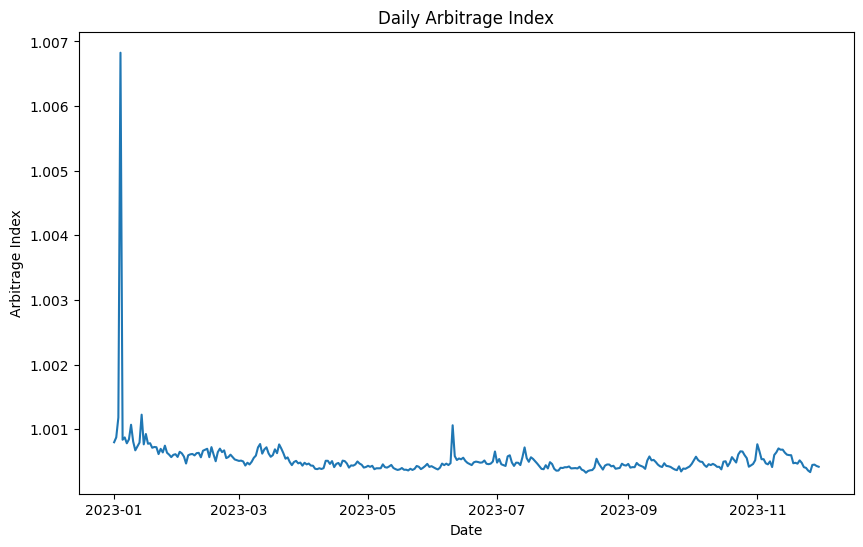

In [33]:
daily_arbitrage_index = vwap_df['Arbitrage Index'].resample('D').mean()

# Plot the daily arbitrage index
plt.figure(figsize=(10,6))
plt.plot(daily_arbitrage_index.index, daily_arbitrage_index.values)

plt.title('Daily Arbitrage Index')
plt.xlabel('Date')
plt.ylabel('Arbitrage Index')

plt.show()

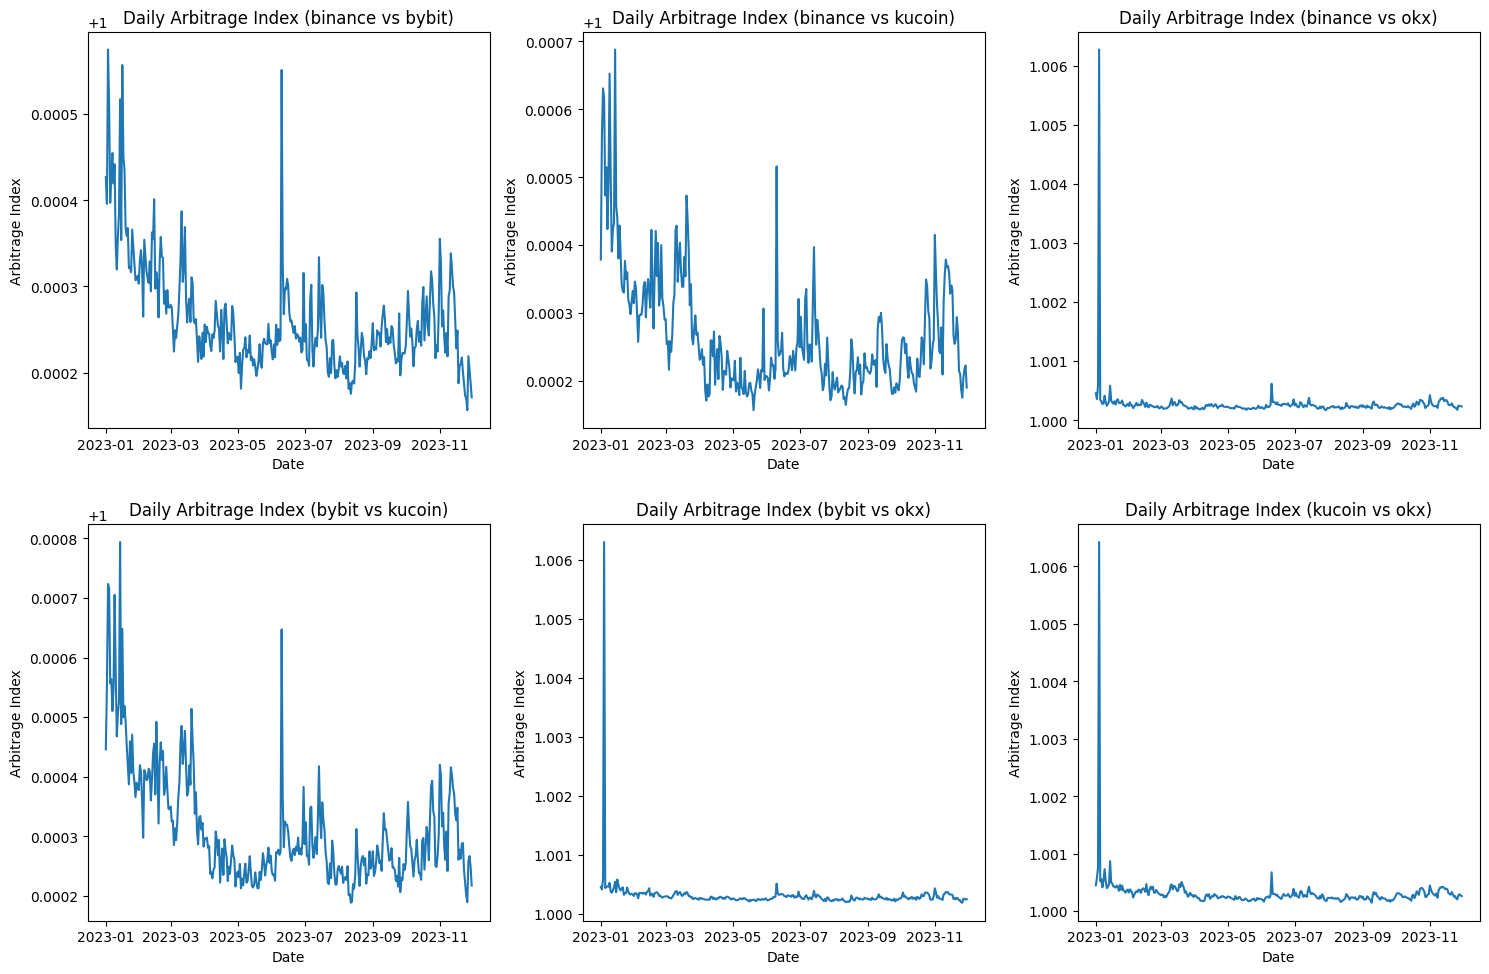

In [35]:
# Define a function to calculate the daily arbitrage index for a pair of exchanges
def calculate_daily_arbitrage_index(df1, df2, exchange1, exchange2):
    # Merge the DataFrames on 'time'
    vwap_df = df1[['time', 'price']].merge(df2[['time', 'price']], on='time', how='inner', suffixes=(f'_{exchange1}', f'_{exchange2}'))
    
    # Calculate the arbitrage index for each row
    vwap_df['Arbitrage Index'] = vwap_df[[f'price_{exchange1}', f'price_{exchange2}']].apply(lambda row: row.max() / row.min(), axis=1)
    
    # Set 'time' as the index
    vwap_df.set_index('time', inplace=True)
    
    # Group by day and calculate the mean of the 'Arbitrage Index' column
    daily_arbitrage_index = vwap_df['Arbitrage Index'].resample('D').mean()
    
    return daily_arbitrage_index

# List of exchanges and their corresponding DataFrames
exchanges = [('binance', binance_df_per_minute), ('bybit', bybit_df_per_minute), ('kucoin', kucoin_df_per_minute), ('okx', okx_df_per_minute)]

# Create a 2x3 subplot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Calculate and plot the daily arbitrage index for each pair of exchanges
# Calculate and plot the daily arbitrage index for each pair of exchanges
for ax, ((exchange1, df1), (exchange2, df2)) in zip(axs.flatten(), itertools.combinations(exchanges, 2)):
    daily_arbitrage_index = calculate_daily_arbitrage_index(df1, df2, exchange1, exchange2)
    ax.plot(daily_arbitrage_index.index, daily_arbitrage_index.values)
    ax.set_title(f'Daily Arbitrage Index ({exchange1} vs {exchange2})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Arbitrage Index')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## Arbitrage profit

In [ ]:
# Define a function to calculate the volume-weighted price and total quantity
def calculate_vwp_and_qty(df, rounded_to='S'):
    # Create a new column 'volume' that represents the volume of each trade
    df['volume'] = df['price'] * df['qty']
    
    # Group by 'time' rounded down to the nearest second
    grouped = df.groupby(df['time'].dt.floor(rounded_to))
    
    # Calculate the volume-weighted price and total quantity for each group
    vwp = (grouped['volume']).sum() / grouped['qty'].sum()
    total_qty = grouped['qty'].sum()
    
    # Return a DataFrame with the 'time', 'price', and 'quantity' columns
    return pd.DataFrame({'time': vwp.index, 'price': vwp.values, 'qty': total_qty.values})

# Calculate the volume-weighted price and total quantity for each dataset
binance_df = calculate_vwp_and_qty(binance_df, 'S')
bybit_df = calculate_vwp_and_qty(bybit_df, 'S')
kucoin_df = calculate_vwp_and_qty(kucoin_df, 'S')
okx_df = calculate_vwp_and_qty(okx_df, 'S')

# Print the first few rows of each DataFrame
print(binance_df.head())
print(bybit_df.head())
print(kucoin_df.head())
print(okx_df.head())

We save this new files that have fewer data

In [3]:
# Merge the DataFrames on 'time'
merged_df = pd.merge(binance_df,bybit_df, on='time', how='outer', suffixes=('_binance', '_bybit'))
merged_df = pd.merge(merged_df, kucoin_df, on='time', how='outer', suffixes=('', '_kucoin'))
merged_df = pd.merge(merged_df, okx_df, on='time', how='outer', suffixes=('_kucoin', '_okx'))

# Calculate the maximum and minimum price for each second
merged_df['max_price'] = merged_df[['price_binance', 'price_bybit', 'price_kucoin', 'price_okx']].max(axis=1)
merged_df['min_price'] = merged_df[['price_binance', 'price_bybit', 'price_kucoin', 'price_okx']].min(axis=1)

# Find all the seconds where the difference between the maximum and minimum price is at least 2%
merged_df['price_diff'] = (merged_df['max_price'] - merged_df['min_price']) / merged_df['min_price']
seconds_with_2_percent_diff = merged_df[merged_df['price_diff'] >= 0.02]['time']

# Print the number of seconds where there is a difference of at least 2% in the price
print(len(seconds_with_2_percent_diff))

3504


In [4]:
seconds_with_2_percent_diff

120981      2023-01-04 04:13:08
120989      2023-01-04 04:13:17
120993      2023-01-04 04:13:21
120994      2023-01-04 04:13:22
120995      2023-01-04 04:13:23
                   ...         
12118798    2023-01-04 10:06:34
12118807    2023-01-04 10:09:41
12118811    2023-01-04 10:13:13
12118828    2023-01-04 10:17:43
12118835    2023-01-04 10:19:15
Name: time, Length: 3504, dtype: object

all trades happens in the same day january 4th 2023

In [9]:
# Filter the DataFrame using the 'seconds_with_2_percent_diff' Series
filtered_df = merged_df.loc[merged_df['time'].isin(seconds_with_2_percent_diff)]

# Convert the price columns to a numeric type
price_columns = ['price_binance', 'price_bybit', 'price_kucoin', 'price_okx']
#astype float
filtered_df[price_columns] = filtered_df[price_columns].astype(float)

# Initialize the total profit
total_profit = 0

# Iterate over the rows in 'filtered_df'
for _, row in filtered_df.iterrows():
    max_price_exchange = row[['price_binance', 'price_bybit', 'price_kucoin', 'price_okx']].fillna(-float('inf'))
    min_price_exchange = row[['price_binance', 'price_bybit', 'price_kucoin', 'price_okx']].fillna(float('inf'))
    
    # Get the exchange with the maximum and minimum price
    max_price_exchange = max_price_exchange.idxmax().split('_')[1]
    min_price_exchange = min_price_exchange.idxmin().split('_')[1]
    
    # Calculate the volume to trade as the minimum of the two volumes
    volume_to_trade = min(row[f'qty_{max_price_exchange}'], row[f'qty_{min_price_exchange}'])
    
    # Calculate the profit as the difference between the selling price and the buying price multiplied by the volume
    profit = volume_to_trade * (row[f'price_{max_price_exchange}'] - row[f'price_{min_price_exchange}'])
    
    # Add the profit to the total profit
    total_profit += profit

# Print the total profit
print(total_profit)

56254.822375280906


You could earn at most 56254$ if you did arbitrage the 4th january 2023